In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import cupy as cp

C:\ProgramData\Anaconda3\lib\site-packages\cupy\_environment.py:435: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda115

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [102]:
# load data
df = pd.read_pickle('clean_data.p')
pd.set_option("display.max_columns", None)
df.head()

,Fecha,Even_mon,ID,Especie,Escenario,Estrategia,Tipo,No_Nuc/Faj/Mod,Línea,No_Ind,Sup_Ind,Est_Fit,COL,VB,HER,PAT,COM,DM,ANE,PNE,Alt_Ind,DAB1_Ind,DAB2_Ind,DAB_Prom,Diam1_Ind,Diam2_Ind,Area_cop_Ind,Observaciones,est_0,est_1,est_2,est_3,est_4
0,2020-11-01,T1,1,Verbesina crassiramea,Pastos limpios,Nucleación,1,1,1,1,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,9.0,<NA>,9.0,30.0,32.0,480.0,<NA>,1,0,0,0,0
1,2020-11-01,T1,2,Verbesina crassiramea,Pastos limpios,Nucleación,1,1,1,2,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,NaN,NaN,0.0,<NA>,1,0,0,0,0
2,2020-11-01,T1,3,Verbesina crassiramea,Pastos limpios,Nucleación,1,1,1,3,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,19.0,<NA>,19.0,94.0,62.0,2914.0,<NA>,1,0,0,0,0
3,2020-11-01,T1,4,Lupinus interruptus,Pastos limpios,Nucleación,1,1,1,4,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,10.0,<NA>,10.0,63.0,38.0,1197.0,<NA>,1,0,0,0,0
4,2020-11-01,T1,5,Lupinus interruptus,Pastos limpios,Nucleación,1,1,1,5,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,NaN,NaN,0.0,Muerto,0,0,0,0,0


*** Start with mortality ***

In [3]:
def split_by_event(df, columns=None):
    ''' Groups data into separate dataframes by data collection event.
    INPUTS: df: pandas DataFrame
            columns (optional): Array-like referring to the desired column names.
                                Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: df_dict: a dictionary of DataFrames or arrays where each key refers to a single data gathering event.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for time_period in df['Even_mon'].unique():
        df_dict[time_period] = df[df['Even_mon'] == time_period][col]
    return df_dict


In [4]:
def split_by_factor(df, factor, columns=None):
    ''' Groups data into separate dataframes by a column. Best used after split_by_event()
    INPUTS: 
    df: (pandas DataFrame) the data to be split
    factor: (str) refers to the column by which the data will be divided
    columns (optional): (array-like) refers to the desired column names.
                        Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: 
    df_dict: (dict) stores DataFrames or arrays where each key refers to a unique factor value.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for factor_value in df[factor].unique():
        df_dict[factor_value] = df[df[factor] == factor_value][col]
    return df_dict

In [70]:
def get_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, p_val=0.00005, plot=False):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits the parameters.
        Works best when run multiple times to get a distribution of sample sizes.
    INPUTS:
    data: (array-like) data to be selected from.
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    p_val: (float) indicates the desired closeness to the mean of the original data 0.01 would be 99% similarity
    plot: (bool) a value of True will plot the means obtained in the simulations as a histogram.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    # TODO: Optional. Integrate warnings for when the sample size surpasses n_obs
    n_obs = data.shape[0]
    param = data.mean()
    sample_size = starting_sample_size
    sim_mean = 0
    unstable = True
    print(n_obs, param)
    print('Finding early size...')
    # Rapidly approach a minimum viable sample size
    while (np.abs(sim_mean - param) > p_val):
        sample_props = np.random.choice(data, size=(n_sims, sample_size))
        sim_mean = sample_props.mean()
        sample_size += learning_rate
        print(sample_size)
        if sample_size >= n_obs:
            print('No adequate sample size for this level of precision.')
            print('Reduce p_val or increase the size of your data')
            return n_obs
    print('Done!')
    print()
    print('Finding stable size...')
    
    # Increment sample size more slowly until it stops increasing
    while unstable:
        counter = 0
        sim_mean_list = []
        while counter < 10:
            sample_props = np.random.choice(data, size=(n_sims, sample_size))
            if plot:
                to_plot = []
                for arr in sample_props:
                    to_plot.append(arr.mean())
            sim_mean_list.append(sample_props.mean())
            counter += 1
        for sim_mean in sim_mean_list:
            if np.abs(sim_mean - param) > p_val:
                sample_size += learning_rate
                break
            else:
                unstable = False
        print(sample_size)
        if sample_size >= n_obs:
            print('No adequate sample size for this level of precision.')
            print('Reduce p_val or increase the size of your data')
            return n_obs
    print('Done!')
    print()
    smallest_stable_sample = sample_size
    
    if plot:
        plt.hist(to_plot, bins=15);
    # print(f'The smallest sample size to match the overall mean of {param} is {smallest_stable_sample}')
    return smallest_stable_sample

In [130]:
def cp_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, p_val=0.0001, plot=False):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits the parameters.
        Works best when run multiple times to get a distribution of sample sizes. uses CuPy instead of NumPy.
    INPUTS:
    data: (array-like) data to be selected from
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    p_val: (float) indicates the desired closeness to the mean of the original data 0.01 would be 99% similarity
    plot: (bool) a value of True will plot the means obtained in the simulations as a histogram.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    n_obs = data.shape[0]
    param = data.mean()
    sample_size = starting_sample_size
    sim_mean = 0
    unstable = True
    
    # Rapidly approach a minimum viable sample size
    while np.abs(sim_mean - param) > p_val:
        sample_props = cp.random.choice(data, size=(n_sims, sample_size))
        sim_mean = sample_props.mean()
        sample_size += learning_rate
        if sample_size >= n_obs:
            return n_obs
        
    # Increment sample size more slowly until it stops increasing
    while unstable:
        counter = 0
        sim_mean_list = []
        while counter < 10:
            sample_props = cp.random.choice(data, size=(n_sims, sample_size))
            np_props = cp.asnumpy(sample_props)
            del sample_props
            if plot:
                to_plot = []
                for arr in np_props:
                    to_plot.append(arr.mean())
            sim_mean_list.append(np_props.mean())
            
            counter += 1
        for sim_mean in sim_mean_list:
            if np.abs(sim_mean - param) > p_val:
                sample_size += learning_rate
                break
            else:
                unstable = False
        if sample_size >= n_obs:
            return n_obs

    smallest_stable_sample = sample_size
    
    if plot:
        plt.hist(to_plot, bins=15);
    # print(f'The smallest sample size to match the overall mean of {param} is {smallest_stable_sample}')
    return smallest_stable_sample

In [7]:
survival_dict = split_by_event(df, ['Especie', 'Sup_Ind'])

In [8]:
survival_1_species_dict = split_by_factor(survival_dict['T1'], 'Especie')

In [9]:
import itertools

testing_subset = dict(itertools.islice(survival_1_species_dict.items(), 3))

In [102]:
testing_subset.keys()

dict_keys(['Verbesina crassiramea', 'Lupinus interruptus', 'Solanum oblongifolium'])

In [103]:
testing_subset['Verbesina crassiramea']['Sup_Ind'].mean()

0.9833147942157954

In [104]:
testing_samples = np.random.choice(testing_subset['Verbesina crassiramea']['Sup_Ind'], size = (100000, 1000))
testing_samples.mean()

0.98333076

In [32]:
mortality_dict['T1']['Sup_Ind'].mean()

0.9630188679245283

(array([208., 330., 225., 101.,  85.,  32.,   6.,  10.,   1.,   2.]),
 array([120., 147., 174., 201., 228., 255., 282., 309., 336., 363., 390.]),
 <BarContainer object of 10 artists>)

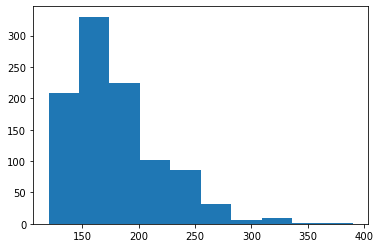

In [85]:
# If we're only worried about mortality, we can reduce our sample size by nearly 90%
to_plot = []
for i in range(1000):
    to_plot.append(get_smallest_sample_size(survival_dict['T1']['Sup_Ind'], learning_rate=10, plot=False))
plt.hist(to_plot)

(array([125., 197., 216., 155.,  70., 101.,  64.,  34.,  19.,   3.,   8.,
          5.,   1.,   0.,   2.]),
 array([120., 138., 156., 174., 192., 210., 228., 246., 264., 282., 300.,
        318., 336., 354., 372., 390.]),
 <BarContainer object of 15 artists>)

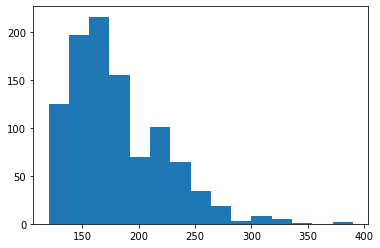

In [86]:
# As above but with more bins
plt.hist(to_plot, bins=15)

In [97]:
def sim_and_plot_stat(df, param, small_pops=False, p_val=0.0001):
    event_split = split_by_event(df, [param, 'Sup_Ind'])
    periods = len(event_split)
    lower_limit = 100
    learning_rate = 5
    n_iter = 100
    # For simulating stats from groups smaller than 100. 
    # Probably inaccurate but it lets you see how it would work.
    # TODO: Include a warning about setting small_pops as True.
    if small_pops:
        lower_limit = 10
        learning_rate = 2    
    
    max_length = 0
    for event in event_split:
        current_length = len(event_split[event][param].unique())
        if current_length > max_length:
            max_length = current_length
    fig, ax = plt.subplots(max_length, periods, figsize=(10, 3*max_length))    
    
    for count1, event in enumerate(event_split):
        sim_set = split_by_factor(event_split[event], param)
        num_data = len(sim_set)

        # Progressbar
        cnter = 0
        maxval = num_data*n_iter
        bar = progressbar.ProgressBar(maxval=maxval, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()

        total_obs = 0
        reduced_obs = 0

        for count2, key in enumerate(sim_set):
            to_plot = []
            if len(sim_set[key]) > lower_limit:
                for i in range(n_iter):
                    # TODO: optimize for most specific p-value
                    # TODO: (optional) fix progressbar
                    # TODO: Fix visualization labels and prettify
                    data = sim_set[key]['Sup_Ind']
                    n_obs = data.shape[0]
                    arr_gpu = cp_smallest_sample_size(data, learning_rate=learning_rate, p_val=p_val)
                    to_plot.append(arr_gpu)
                    del arr_gpu
                    cnter += 1
                    bar.update(cnter)
                _ = ax[count2, count1].hist(to_plot, bins=10)
                ax[count2, count1].set_ylabel(f'{param, key}\nPopulation: {n_obs}\nImprovement: {max(to_plot)/n_obs}', rotation=0)
                reduced_obs += max(to_plot)
            else:
                data = sim_set[key]['Sup_Ind']
                n_obs = data.shape[0]
                _ = ax[count2, count1]
                ax[count2, count1].set_ylabel(f'{param, key}\nSample the entire population of {n_obs}')
                cnter += n_iter
                bar.update(cnter)
                reduced_obs += n_obs
            total_obs += n_obs
        print(f'Original survey: {total_obs}')
        print(f'Reduced survey: {reduced_obs}')
        print(f'percentage improvement: {(total_obs-reduced_obs)/total_obs}')
        
    fig.tight_layout()
    

In [90]:
t = df.groupby(['Even_mon', 'Especie']).count().reset_index()[['Even_mon','Especie']]
print(t[t['Even_mon'] == 'T1']['Especie'].unique())
print(t[t['Even_mon'] == 'T2']['Especie'].unique())
print(t[t['Even_mon'] == 'T3']['Especie'].unique())

<StringArray>
[            'Ageratina ampla',        'Ageratina boyacensis',
            'Aniba panurensis',                 'Axinaea sp.',
         'Baccharis latifolia',         'Bocconia frutescens',
    'Brunellia comocladifolia',             'Cedrela montana',
           'Ceroxylon alpinum',        'Chamaedorea linearis',
      'Cordia cylindrostachya',        'Croton magdalenensis',
       'Escallonia paniculata',            'Guarea kunthiana',
          'Hedyosmum crenatum',          'Juglans neotropica',
              'Lippia hirsuta',         'Lupinus interruptus',
                 'Miconia sp.',           'Morella pubescens',
       'Myrcianthes leucoxyla',            'Myrsine coriacea',
           'Oreopanax incisus',     'Palicourea angustifolia',
             'Piper nubigenum',          'Quercus humboldtii',
   'Retrophyllum rospigliosii',          'Rhamnus goudotiana',
     'Smallanthus pyramidalis',       'Solanum oblongifolium',
       'Verbesina crassiramea',          

[                                                                        ]   0%

Original survey: 3975
Reduced survey: 2162
percentage improvement: 0.4561006289308176


[                                                                        ]   0%

Original survey: 3982
Reduced survey: 2270
percentage improvement: 0.4299347061778001


[=========================================                               ]  57%

Original survey: 3986
Reduced survey: 2273
percentage improvement: 0.42975413948820873


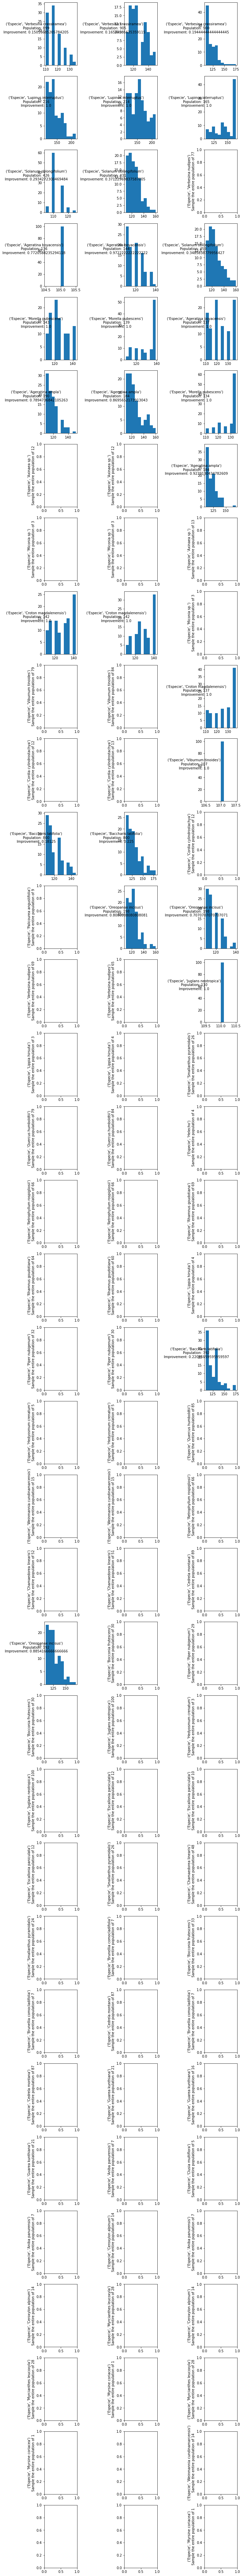

In [98]:
#If we're only worried about species, we can reduce our sample size by over 40%
sim_and_plot_stat(df, 'Especie')

[                                                                        ]   0%

Original survey: 3975
Reduced survey: 506
percentage improvement: 0.8727044025157232


[                                                                        ]   0%

Original survey: 3982
Reduced survey: 475
percentage improvement: 0.8807132094424912


[========================================================================] 100%

Original survey: 3986
Reduced survey: 531
percentage improvement: 0.8667837431008529


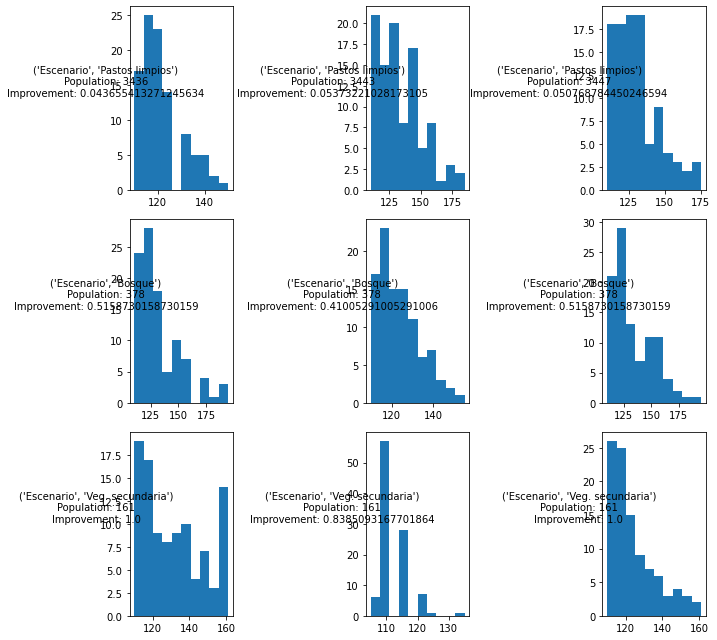

In [99]:
#If we're only worried about different types of arrangements, we can reduce our sample size by over 80%
sim_and_plot_stat(df, 'Escenario')

[========================================================                ]  77%

Original survey: 3975
Reduced survey: 3868
percentage improvement: 0.02691823899371069


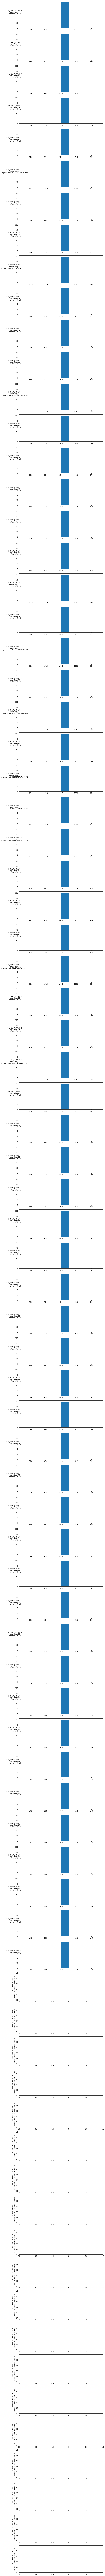

In [79]:
# When we simulate by groups based on geographic location, our simulation gets way more imprecise.
# This is where machine learning could help, potentially.
sim_and_plot_stat(df, 'No_Nuc/Faj/Mod', small_pops=True, p_val=0.01)

In [133]:
mempool = cp.get_default_memory_pool()
print(mempool.used_bytes()) 
print(mempool.total_bytes())

50657280
64418816


In [132]:
mempool.free_all_blocks()

In [117]:
# TODO: Fix data cleaning dtypes
test_health = np.array(split_by_event(df)['T1']['Est_Fit']).astype('int')

    

In [118]:
test_health

array([0, 0, 0, ..., 5, 5, 5])

In [115]:
type(test_health)

numpy.ndarray

190

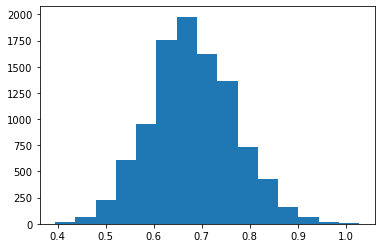

In [134]:
cp_smallest_sample_size(test_health, plot=True)

In [135]:
cp_smallest_sample_size(test_health)

380

(array([ 8.,  0., 55.,  0.,  0., 30.,  0.,  3.,  0.,  4.]),
 array([105., 107., 109., 111., 113., 115., 117., 119., 121., 123., 125.]),
 <BarContainer object of 10 artists>)

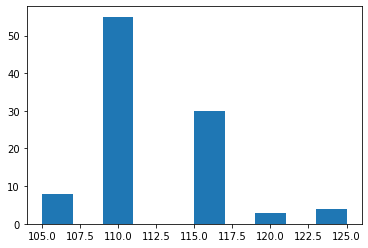

In [123]:
sim_cols = ['Sup_Ind', 'Est_Fit', 'COL', 'VB',
                       'HER', 'PAT', 'COM', 'DM', 'ANE', 'PNE', 'Alt_Ind',
                       'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind', 'Area_cop_Ind']
group_cols = ['Even_mon', 'Especie', 'Escenario', 'Estrategia']
desired_stats = ['mean', 'std', 'var']
'''PSUDOCODE:
Main function: calls sim_stat for each sim column to simulate each stat for each groupby column
    if Even_mon: just do it for the whole population
    else: group by Even_mon first and then by the right stat
    
    Must display results of all sims in terms of improvement: original / new_min
    Optionally it should plot in a double bar graph original under main
    Probably need a separate dataframe for each group_col
    
    
'''

In [139]:
df.HER.dtype == 'float64'

True

In [118]:
import time
np_start = time.perf_counter()
counter = 0
while counter < 1000:
    get_smallest_sample_size(testing_subset['Verbesina crassiramea']['Sup_Ind'], learning_rate=10)
    counter += 1
np_end = time.perf_counter()
print(f"time for np: {np_end-np_start:0.4f} seconds")

cp_start = time.perf_counter()
counter = 0
while counter < 1000:
    cp_smallest_sample_size(testing_subset['Verbesina crassiramea']['Sup_Ind'], learning_rate=10)
    counter += 1
cp_end = time.perf_counter()
print(f"time for cp: {cp_end-cp_start:0.4f} seconds")


time for np: 329.6113 seconds
time for cp: 45.0637 seconds
